In [1]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
k = keras.backend

# Variational AutoEncoders For Generating Fashion MNIST Dataset Generation

In [2]:
# loading the MNIST data
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [33]:
# we first need to implement a custom layer so we can sample codings given Mean(m), and the Gama log(variance ** 2) 
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return k.random_normal(tf.shape(log_var)) * k.exp(log_var / 2) + mean 

In [34]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [35]:
# next we need to build our encoder
codings_size = 10

inputs = keras.layers.Input(shape = [28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation='selu')(z)
z = keras.layers.Dense(100, activation = 'selu')(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])

encoder = keras.models.Model(inputs = [inputs],
                             outputs = [codings, codings_mean, codings_log_var])


decoder_inputs = keras.layers.Input(shape = [codings_size])

x = keras.layers.Dense(100, activation = "selu")(decoder_inputs)
x = keras.layers.Dense(150, activation = 'selu')(x)
x = keras.layers.Dense(28 * 28, activation = 'sigmoid')(x)
decoder_outputs = keras.layers.Reshape(target_shape=[28, 28])(x)

decoder_model = keras.models.Model(inputs = (decoder_inputs),
                                   outputs = (decoder_outputs))

codings, _, _ = encoder(inputs)
reconstructions = decoder_model(codings)
vartiational_ae = keras.models.Model(inputs = (inputs),
                                     outputs = (reconstructions))

latent_loss = -0.5 * k.sum(1 + codings_log_var - k.exp(codings_log_var) - k.square(codings_mean), axis = -1)
vartiational_ae.add_loss(k.mean(latent_loss)/ 784.)
vartiational_ae.compile(loss = 'binary_crossentropy', optimizer= "rmsprop", metrics = [rounded_accuracy])

In [36]:
history = vartiational_ae.fit(X_train, X_train, epochs = 50, batch_size = 128,
                              validation_data=[X_test, X_test])

Epoch 1/50
430/430 [==============================] - 5s 8ms/step - loss: 0.4140 - rounded_accuracy: 0.8369 - val_loss: 0.3761 - val_rounded_accuracy: 0.8834
Epoch 2/50
430/430 [==============================] - 3s 7ms/step - loss: 0.3548 - rounded_accuracy: 0.8903 - val_loss: 0.3469 - val_rounded_accuracy: 0.8989
Epoch 3/50
430/430 [==============================] - 3s 6ms/step - loss: 0.3440 - rounded_accuracy: 0.8979 - val_loss: 0.3427 - val_rounded_accuracy: 0.8968
Epoch 4/50
430/430 [==============================] - 3s 6ms/step - loss: 0.3374 - rounded_accuracy: 0.9030 - val_loss: 0.3366 - val_rounded_accuracy: 0.9051
Epoch 5/50
430/430 [==============================] - 3s 7ms/step - loss: 0.3327 - rounded_accuracy: 0.9065 - val_loss: 0.3320 - val_rounded_accuracy: 0.9091
Epoch 6/50
430/430 [==============================] - 3s 7ms/step - loss: 0.3295 - rounded_accuracy: 0.9087 - val_loss: 0.3310 - val_rounded_accuracy: 0.9065
Epoch 7/50
430/430 [==============================] 

In [46]:
def show_reconstructions(model, images = X_test, n_images = 5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(1.5 * n_images, 3))
    for image_idx in range(n_images):
        plt.subplot(2, n_images, 1 + image_idx)
        plt.imshow(images[image_idx], cmap = "gray")
        plt.axis(False)
        plt.subplot(2, n_images, 1 + image_idx + n_images)
        plt.imshow(reconstructions[image_idx], cmap = "gray")
        plt.axis(False)

1/1 [==============================] - 0s 18ms/step


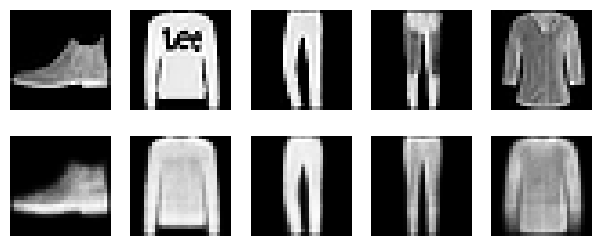

In [47]:
show_reconstructions(vartiational_ae)

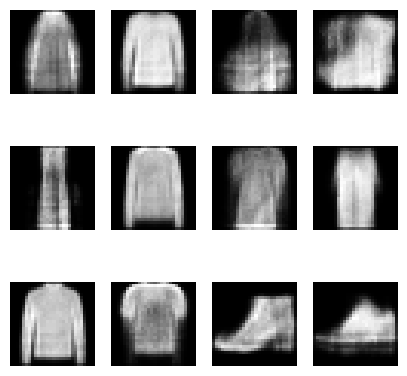

In [61]:
# Generating a Fashion mnist images by sampling from a gaussian distribution and input that to the decoder model
codings = tf.random.normal(shape = [12, codings_size])
images = decoder_model(codings).numpy()
n_images = images.shape[0]
fig = plt.figure(figsize =(5, 5))
for image_idx in range(n_images):
    plt.subplot(3, 4, 1 + image_idx)
    plt.imshow(images[image_idx], cmap = "gray")
    plt.axis(False)

# Lets See what we can do with GANs

- As we know that A GAN network contains a Generator and Discriminator
- Each of them competite to convence the other with his objective
- The generator wants to convence the discriminator that the produced images are real one
- while the discriminator wants to distinguesh real images from the fake ones that  the generator produces
- in the simple training approach we train the discrimnator by labeling a batch of fake images produced by the generator as fake and also a batch of real images from our training dataset labled as real images
- then we train the generator by producing another batch of fake images but label them as real and freez the trainable parameters of the discriminator as we're convencing the discriminator that these images are real so the generator learns to generate a more realistic images
- we train the generator within the whole gan  model, but train the discriminator independentlly.

In [3]:
# first lets build our generator model it's a simple stacks of dense layer as the decoder of an autoencoder model
codings_size = 30
generator = keras.models.Sequential([
    keras.layers.Dense(100, activation = "selu", input_shape = [codings_size]),
    keras.layers.Dense(150, activation = "selu"),
    keras.layers.Dense(28 * 28, activation = "sigmoid"),
    keras.layers.Reshape(target_shape = [28, 28])
])

# the discriminator is a simple binary classification model that takes a 28 * 28 image and classify weither it's fake or real
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28, 28]),
    keras.layers.Dense(150, activation = "selu"),
    keras.layers.Dense(100, activation = "selu"),
    keras.layers.Dense(30, activation = "selu"),
    keras.layers.Dense(1, activation = "sigmoid")
])

gan_model = keras.models.Sequential([generator, discriminator])

# sense the discriminator and the gan are both making a binary classification task so we can use binary crossentropy as our loss function
discriminator.compile(loss = "binary_crossentropy", optimizer = "rmsprop")
discriminator.trainable = False

gan_model.compile(loss = "binary_crossentropy", optimizer = "rmsprop")



batch_size = 32

dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder = True).prefetch(1)

In [13]:
# then we need to write our training loop as mentioned above

def train_gan(gan : keras.models.Model = gan_model,
              dataset : tf.data.Dataset = dataset,
              batch_size :int = 32,
              codings : int = 20,
              epochs : int = 50):
    
    generator, discriminator = gan.layers

    for epoch in range(epochs):
        print(f"this is epoch : {epoch}")
        for X_batch in dataset:
            noise = tf.random.normal(shape = [batch_size, codings_size])
            generated_images = generator(noise)
            
            X_fake_and_real = tf.concat([generated_images, X_batch], axis = 0)
            y1 = tf.constant([[0]] * batch_size + [[1]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)

            noise = tf.random.normal(shape = [batch_size, codings_size])

            y2 = tf.constant([[1]] * batch_size)
            discriminator.trainable = False

            gan.train_on_batch(noise, y2)
        reconstructions = generator(noise)
    return reconstructions

In [15]:
reconstructions = train_gan(epochs = 1)

this is epoch : 0


In [16]:
reconstructions.shape

TensorShape([32, 28, 28])

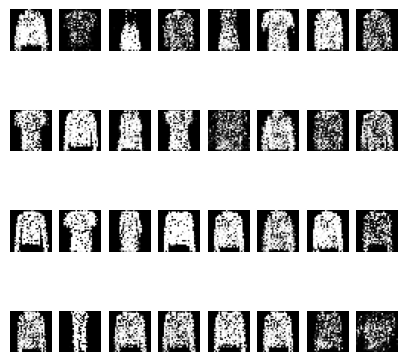

In [21]:
# lets see the reconstructions of the generator just after on epochs
fig = plt.figure(figsize = (5, 5))
for image_idx in range(reconstructions.shape[0]):
    plt.subplot(4, 8, image_idx + 1)
    plt.imshow(reconstructions[image_idx], cmap = "gray")
    plt.axis(False)